# W261 Final Project - Clickthrough Rate Prediction

## Machine Learning at Scale | Section 4 | Fall 2019

#### Team #21

Brent Biseda  
Katie Mo  
Teddy Fong  
Thanh Le  

## Table of Contents
 - Section 1. Project Introduction
     - 1.a. Question Formulation
     - 1.b. Comparison between CSV & Parquet
 - Section 2 - Algorithm Explanation
     - 2.a. Model Selection and Explanation
     - 2.b. Gradient Descent for Logistic Regression
 - Section 3. EDA & Challenges
     - 3.a. Notebook Setup
     - 3.b. Evaluation Metrics
     - 3.c. Categorical Variables EDA
     - 3.d. Numeric Variables EDA
     - 3.e. Reduction of Categories
     - 3.f. Impute Missing Values
     - 3.g. Apply One Hot Encoding and Scale Our Features for Use With Regularization
 - Section 4. Algorithm Implementation and Evaluation
     - 4.a. Single Fold Logistic Regression
     - 4.b. K-Fold Cross Validation for Logistic Regression
     - 4.c. K-Fold Cross Validation for Logistic Regression with Class Weights
     - 4.d. Trying a Random Forest
     - 4.e. Trying a Gradient Boosted Tree
     - 4.f. Submission of Results to Kaggle
 - Section 5. Course Concepts
     - 5.a. Big Data Scalability: Hadoop vs. Spark
     - 5.b. ML Lib
     - 5.c. One Hot Encoding
     - 5.d. Sparse Representation
     - 5.e. Over Fitting & Model Regularization
     - 5.f. Feature Selection and It's Effect on Model Complexity

# 1. Project Introduction

Online advertisements is a fast-growing industry with highly scalable revenue opportunities depending on what platforms the advertisements are on. The marketing industry is focusing heavily on understanding and optimizing Click Through Rate (CTR) prediction in order to maximize the opportunity of revenue. CTR can be thought of as the probability that a user will engage with a particular element of the internet such as an advertisement. There are a plethora of features that can influence CTR such as the ad size, placement, color, font, etc. and we wanted to understand these features. Could machine learning be used to predict and optimize CTR?

The dataset for our final project is the Criteo Display Advertising Challenge from 2014 (https://www.kaggle.com/c/criteo-display-ad-challenge/overview).  This dataset is a sample of the web traffic that CriteoLabs gathered in order to predict Click Through Rate. The data that was provided is entirely anonymized and there is no additional context behind the independent variables provided.  Therefore our line of reasoning and questions were limited to exclude any demographic or domain specific insights.  

## 1.a. Question Formulation

Our goal is to understand if we could use machine learning to predict and optimize CTR with a scalable approach. 

Therefore, our key question was "What feature(s) do we use to create an accurate model from our dataset to predict who will click on the ads?"

From an overarching standpoint, when creating our solution it must be robust.  

1. What design decisions can we make to optimize performance and allow our solution to scale?

Some of the other specific questions that are of interest are as follows:

1. How does One Hot Encoding impact performance and what is the optimal methodology to determine number of categories?  
2. Is K-fold Cross Validation necessary when dealing with sufficiently big data?  
3. What is the trade-off between False Positives and False Negatives?  
4. Does regularization improve our model?
5. What is the best machine learning model to utilize for CTR optimization?

Ultimately, the level of performance a model needs to have depends on the cost of showing advertisements and benefit of advertisement clicks. At a minimum level, the model should perform better than randomly guessing or always predicting the majority class. In this sense, the area under the ROC curve should be greater than 0.5 and the area under the precision recall curve should be greater than the proportion of the minority class.

## 1.b. Comparison between CSV & Parquet

Apache parquet file format is designed to more efficiently store columnar data rather than by row such as using a file format like csv.  Parquet is optimized to minimize file I/O and efficiently compresses.  Parquet can be queried more efficiently with SQL than csv files.  When using a cloud platform, users may be charged by I/O so use of a csv will be more expensive when compared to parquet.  Additionally, because parquet is faster, computation charges are correspondingly lower as well.  Parquet file format may yield a performance improvement around 10x, or an order of magnitude, when compared to performance on a csv.

Additionally, parquet file format allows for easy use of a spark DF as it has performance improvements relative to RDD.  

https://dzone.com/articles/how-to-be-a-hero-with-powerful-parquet-google-and  
https://developer.ibm.com/hadoop/2016/01/14/5-reasons-to-choose-parquet-for-spark-sql/  
https://mapr.com/blog/tips-and-best-practices-to-take-advantage-of-spark-2-x/  

Therefore, we will by using Parquet for our project.

### Please see Final_Project_Support.ipynb for conversion to parquet

In [1]:
from IPython.display import FileLink, FileLinks
FileLink('Final_Project_Support.ipynb')

/media/notebooks/f19-final-project-f19-team-21/Final_Project_Support.ipynb

# 2. Algorithm Explanation

## 2.a. Model Selection and Explanation

When predicting click-through rate (CTR) for a website, our goal is to generate a probability value that is representative of a binary outcome.  Logistic regression is an algorithm that is particularly useful for this task.  That is, we are trying to predict if a user will click on an advertisement or not, we are defining a binary statistic with a probability between 0 and 1.  

The logistic model is useful as it is better able to capture the shape of the probability distribution when compared to other methods such as linear regression.  Logistic regression always creates an S-shaped curve, which, cannot be below 0% or above 100% liklihood, in comparison to linear regression. From this logic, we decided to work on this project by using the logistic regression model, but we did consider and weight other machine learning models such as decision trees, random forests, and neural networks. 

Logistic regression does not have the same rigid assumptions that linear regression may have, and does not require us to scale our data.  However, because we choose to use regularization, we do indeed need to scale our features. 

The assumptions for logistic regression are shown below:  

1. The dependent variable is binary
2. Observations are independent 
3. No multi-collinearity between independent variables
4. Independent variables are related to the log odds

From the above, we are confident that conditions 1 and 2 are satisfied.  Based on our EDA and the independent variables that we eliminated, we can be reasonably confident that condition 3 is also satisfied.  The fourth condition is a reasonable expectation in order to fit a model to the available data.  

The Logistic Regression Equation with Regularization is Shown Below:

$$ p(X) = \frac{e^{\sum_{i=0}^{n}\beta_iX}}{1+e^{\sum_{i=0}^{n}\beta_iX}}$$

$$ min \sum_{i=1}^L(log(1+exp(-y_i\theta))+\frac{\lambda}{2}||w||^2$$

Gareth, James. et al. An Introduction to Statistical Learning with Applications in R.  Springer Publishing.  2015.  
https://en.wikipedia.org/wiki/Logistic_regression  
http://www.cs.rpi.edu/~magdon/courses/LFD-Slides/SlidesLect09.pdf  



## 2.b. Gradient Descent for Logistic Regression

Because the data is large, we cannot solve the parameters for the ideal regressor directly.  Instead, we must apply an algorithm to optimize the loss function.  A common method of optimizing the function is through the use of gradient descent.  That is, we iteratively evaluate points from our dataset then use these to gradually update the parameters of our model.  The mathematical detail to explain the application of this for logistic regression is shown below.

Our rows of data with dependent and independent variables are defined as:  

$$ y = \theta_0 + \theta_1 x + ... + \theta_l x_l = \theta^T x$$

For the case of logistic regression, we can define our function g(z) to provide probability in the range of 0 - 1.  

$$ h_{\theta}(x) = g(\theta^T x) $$

$$ g(z) = \frac{1}{1+e^{-z}} $$

In order to find our optimal parameters we define a loss function.  This loss function is Cross-Entropy or Log Loss rather than RMSE and we define it as:  

$$ L(\hat{y},y) = -(rylog\hat{y} + (1-r)(1-y)log(1-\hat{y}))$$

We can define a cost Function, J, using our notation from h and g as:

$$ h = g(X \theta) $$

$$ J = \frac{\sum_{i=1}^{m} L(\hat{y}^i,y^i)}{m} = -\frac{ \sum_{i=1}^{m} y^ilog\hat{y}^i + (1-y^i)log(1-\hat{y}^i)}{m} $$

$$ J(\theta) = \frac{1}{m}(-y^Tlog(h)-(1-y)^Tlog(1-h))$$

In order to use gradient descent we will want the derivative of the function J at each step.  So we will take the derivative.

$$ \frac{dJ}{d\theta} = x(\hat{y}-y)$$

We will iteratively update the weights of our model by predicting the class then evaluating the derivative until convergence or a maximum number of iterations:

$$ \theta_t = \theta_{t-1} - \alpha \frac{dJ}{d\theta} $$

https://towardsdatascience.com/gradient-descent-demystified-bc30b26e432a  
https://ml-cheatsheet.readthedocs.io/en/latest/logistic_regression.html  
https://spark.apache.org/docs/latest/mllib-linear-methods.html#logistic-regression  

### Please see "Logistic Regression.ipynb" to demonstrate logistic regression using the map reduce paradigm on our toy example data set

In [2]:
from IPython.display import FileLink, FileLinks
FileLink('Logistic Regression.ipynb')

/media/notebooks/f19-final-project-f19-team-21/Logistic Regression.ipynb

# 3. EDA & Challenges

## 3.a. Notebook Setup

In [1]:
# imports
import re
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
import sys
from pyspark.sql import SQLContext
from pyspark.ml.feature import VectorAssembler
import pyspark.sql.functions as F

pd.set_option('display.max_columns', 40)

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

In [4]:
sc = SparkContext(appName="Final_Project")
sqlContext = SQLContext(sc)

In [5]:
# start Spark Session
from pyspark.sql import SparkSession
app_name = "final_project_notebook"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()

In [6]:
spark

In [9]:
sc._conf.getAll()

[('spark.driver.memory', '25g'),
 ('spark.driver.port', '36593'),
 ('spark.app.name', 'final_project_notebook'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.app.id', 'local-1576014274621'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.host', 'docker.w261'),
 ('spark.executor.memory', '25g')]

### Load Data

In [7]:
# Load the parquet files into dataframes
testDF = sqlContext.read.parquet('test.parquet')
trainDF = sqlContext.read.parquet('train.parquet')

After converting the data into a parquet format, we can load the training and test set parquet files. First, we randomly split off 20% of the data in the training set to use as our validation set. We perform this split before continuing our EDA in order to prevent any data leakage.

In [8]:
# Generate 80/20 (pseudo)random train/test split 
start = time.time()
trainDF, validDF = trainDF.randomSplit([0.8,0.2], seed = 1)
print(f"Assigned {trainDF.count()} for training. Assigned {validDF.count()} for Validation.")
print(f"\n... Executed in {time.time() - start} seconds")

Assigned 36668287 for training. Assigned 9172330 for Validation.

... Executed in 409.39777994155884 seconds


In our dataset, we have assigned the first column as our target variable y and the remaining 39 columns are comprised of the features. Of those features, the first 13 columns, x1 to x13, appear to be numeric features and the last 26 columns, x14 to x39, appear to be categorical features.

In [9]:
HEADER = trainDF.columns
INTEGER_FEATURES = HEADER[0:14] # These are the integer features
CATEGORICAL_FEATURES = HEADER[14:] # These are the categorical features

In [12]:
#find number of examples in each class and in total
train_count = trainDF.count()

trainDF_0 = trainDF.where(F.col("y") == 0)
train_count_0 = trainDF_0.count()

trainDF_1 = trainDF.where(F.col("y") == 1)
train_count_1 = trainDF_1.count()

print("There are {} examples in the training set in total, with {} ({:0.2f}%) in class 0 and {} ({:0.2f}%) in class 1." \
      .format(train_count, train_count_0, (train_count_0/train_count)*100, train_count_1, (train_count_1/train_count)*100))

There are 36668287 examples in the training set in total, with 27272663 (74.38%) in class 0 and 9395624 (25.62%) in class 1.


In [121]:
valid_count = validDF.count()
validDF_0 = validDF.where(F.col("y") == 0)
valid_count_0 = validDF_0.count()
validDF_1 = validDF.where(F.col("y") == 1)
valid_count_1 = validDF_1.count()
print("There are {} examples in the validation set in total, with {} ({:0.2f}%) in class 0 and {} ({:0.2f}%) in class 1." \
      .format(valid_count, valid_count_0, (valid_count_0/valid_count)*100, valid_count_1, (valid_count_1/valid_count)*100))

There are 9172355 examples in the validation set in total, with 6822527 (74.38%) in class 0 and 2349828 (25.62%) in class 1.


In both of our training and validation sets, we see a large imbalance in the number of examples in each class. There are 74.38% of observations in class 0 in the training and validation set. This class imbalance in our dataset is an important aspect in our decision of our evaluation metric and algorithm implementation.

In [123]:
test_count = testDF.count()
print("There are {} examples in the test set in total".format(test_count))

There are 6042135 examples in the test set in total


## 3.b. Evaluation Metrics

Accuracy is not a good measure for this dataset because it is not balanced.  If we were to always predict that the user would not click on the advertisement, we would score a high accuracy because that is the predominant class.  There are some methods to deal with this aspect of the data, such as undersampling or oversampling, however, we were instructed that the dataset has already been resampled.  Accuracy is a good metric only if the data is uniformly distributed.  Therefore, we must choose other metrics in order to evaluate the performance of our model.  

Precision and recall are other metrics that we should consider.

$$ Precision = \frac{True Positives}{True Positives + False Positives}$$

$$ Recall = \frac{True Positives}{True Positives + False Negatives}$$

$$ F_1Score = 2\frac{Precision * Recall}{Precision + Recall}$$

Precision describes how well we are able to identify the true class.  As an example, a very high precision score occurs when there are few false positives.  A high precision score would occur if we correctly identify when people click on the add, but we may be missing many of the other clicks but we have very few false positives.

Recall describes how well we identify all of the positive class examples.  A high recall score occurs when we identify all of the clicks.  In this case, if we were to identify all ads as being clicked on, we would have a perfect Recall score, but have a very low precision.

The F score is the harmonic mean of Precision & Recall and can serve as a good metric to understand the trade-off between Precision & Recall.

![Under Sampling](support/under_sampling.png)

There are two other metrics that are also useful for us to evaluate the performance of our model: The ROC Curve, and the Precision-Recall Curve.  

The ROC (Receiver Operating Characteristic) Curve is a plot that shows the False Positive Rate on the X-axis, and the True Positive Rate on the y-axis.  The score is defined as the area under the curve.  It assists in the use of defining a threshold by which we can define our model.  We can tune the threshold to determine how many false positives we can tolerate in order to increase the number of true positives that we capture.  As an example, we could focus more effort and advertisement dollars on the individuals that we are very confident that they will click.

Similarly, the precision-recall curve plots recall along the X-axis with precision along the y-axis.  The score is defined as the area under the curve.  Just like with the ROC, we can tune our model by adjusting our recall to determine what precision we would accept.  

We ultimately use the area under the precision-recall curve in order to optimize our model.  This is well suited to deal with an imbalanced data set.

http://www.davidsbatista.net/blog/2018/08/19/NLP_Metrics/  
https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/  

## 3.c. Categorical Variables EDA

For our 26 categorical variables, we found that 12 of them contain missing values. 5 of these variables contain a significant amount of missing values: columns x32, x33, x38, and x39 have 44.01% missing values, while column x35 has 76.25% missing values. For these features with large proportion of missing values, we will treat the missing values as its own category.

We also noticed that some of the categorical variables have a high proportion of unique values. From the cell results below we may consider excluding the features with too many unique values to be able to generalize the data: x16, x17, x25, x29, x34, and x37. Alternatively, we can combine less frequent values into one category.

In [15]:
#find percentage of missing values for categorical features

for feature in CATEGORICAL_FEATURES:
    num_unique = trainDF.select(feature).distinct().count()
    percent_missing = (trainDF.filter(f"{feature} == ''").count() / train_count )*100
    print("{} has {} unique values and {:0.2f}% missing values".format(feature, num_unique, percent_missing))

x14 has 1460 unique values and 0.00% missing values
x15 has 580 unique values and 0.00% missing values
x16 has 8379583 unique values and 3.40% missing values
x17 has 1883914 unique values and 3.40% missing values
x18 has 305 unique values and 0.00% missing values
x19 has 24 unique values and 12.09% missing values
x20 has 12482 unique values and 0.00% missing values
x21 has 633 unique values and 0.00% missing values
x22 has 3 unique values and 0.00% missing values
x23 has 88969 unique values and 0.00% missing values
x24 has 5645 unique values and 0.00% missing values
x25 has 6951672 unique values and 3.40% missing values
x26 has 3193 unique values and 0.00% missing values
x27 has 27 unique values and 0.00% missing values
x28 has 14738 unique values and 0.00% missing values
x29 has 4590562 unique values and 3.40% missing values
x30 has 10 unique values and 0.00% missing values
x31 has 5576 unique values and 0.00% missing values
x32 has 2167 unique values and 44.01% missing values
x33 has

Our next question for categorical variables EDA is to understand which features would provide useful information to distinguish between the two classes. Because of the sheer number of unique values that we would need to one hot encode, we only want to include the most useful features for computational efficiency in scalability. To answer this question, we went through each feature, found the top 10 most frequent values for each class, and plotted the value’s frequency by class on a bar graph. Frequency by class was plotted rather than count so that we can easily compare the proportions of each value between the two classes. 

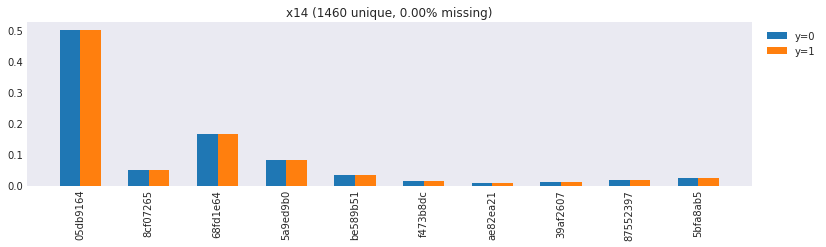

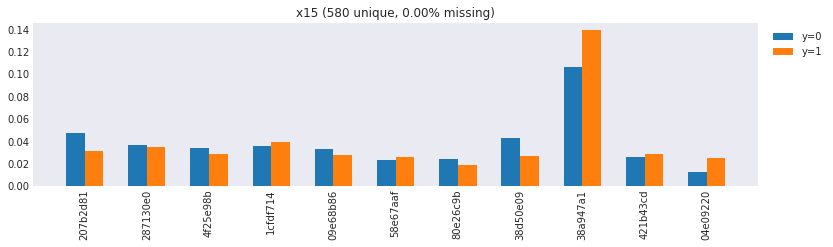

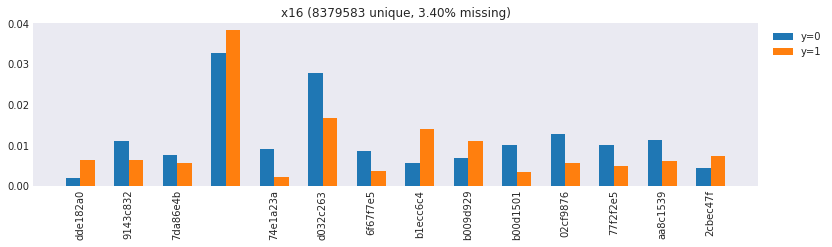

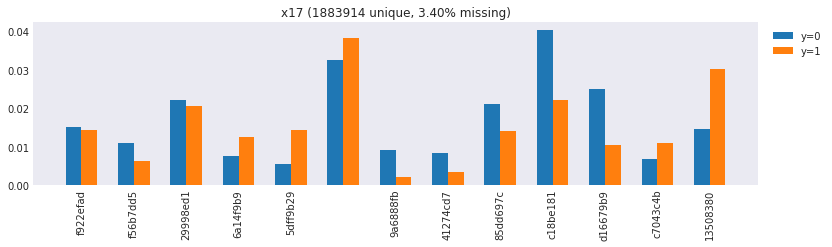

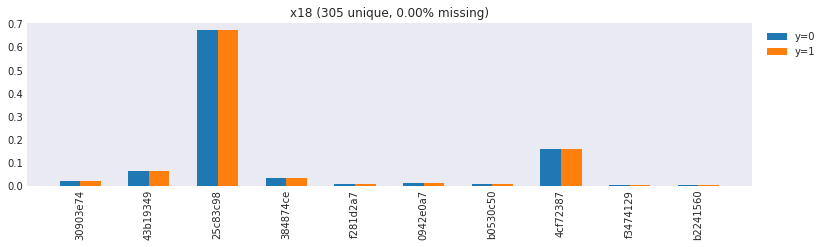

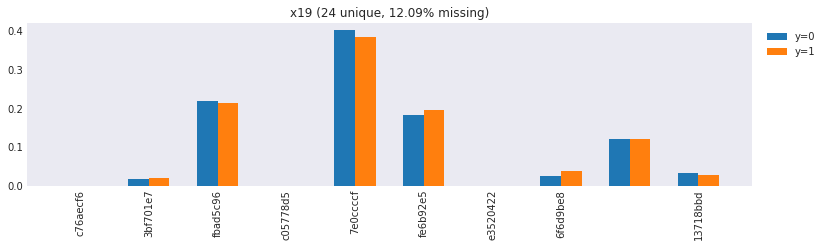

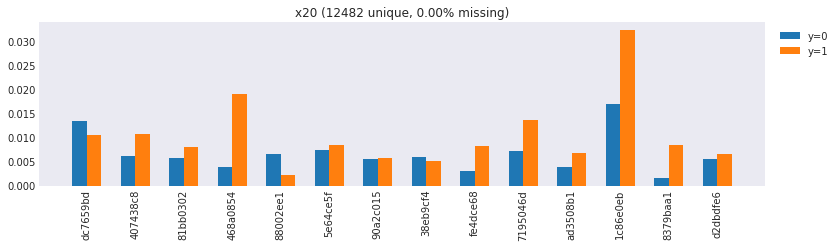

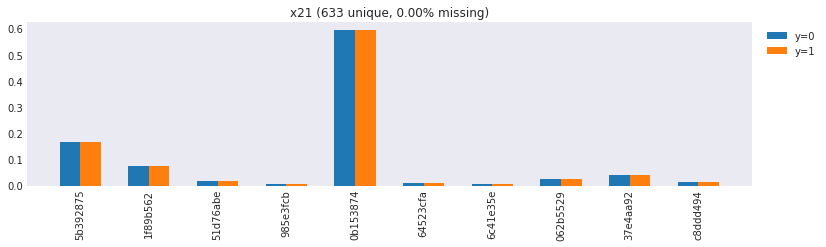

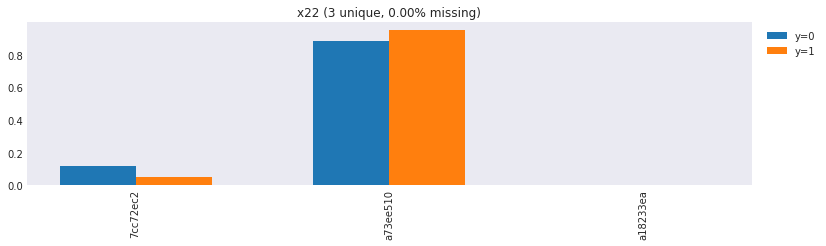

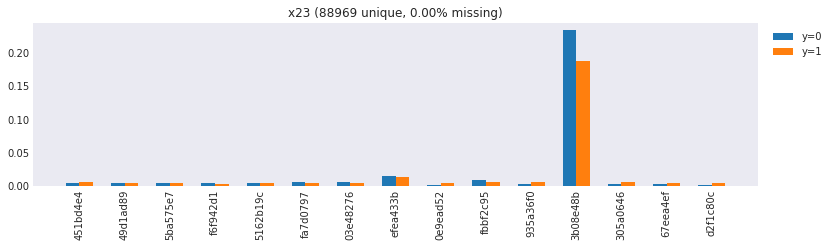

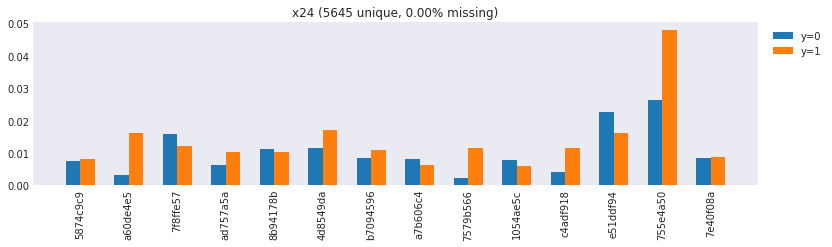

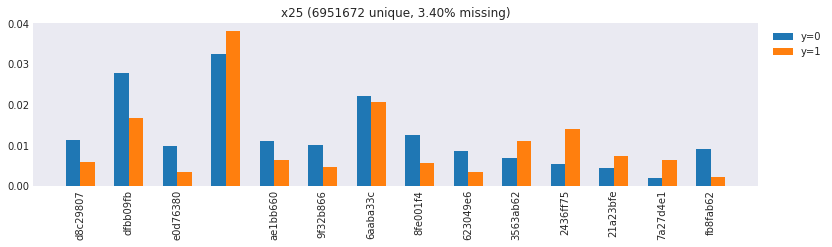

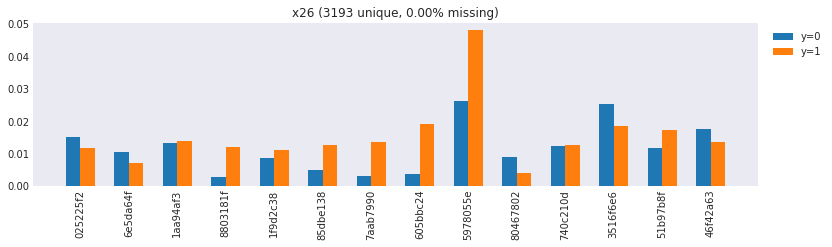

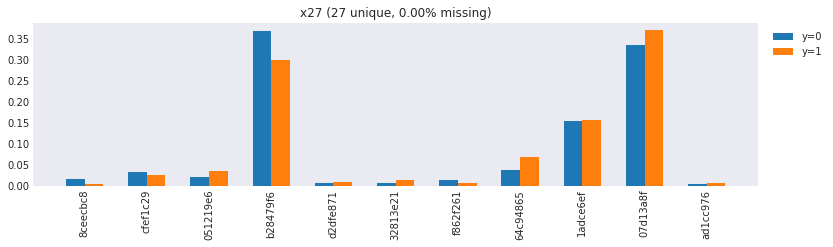

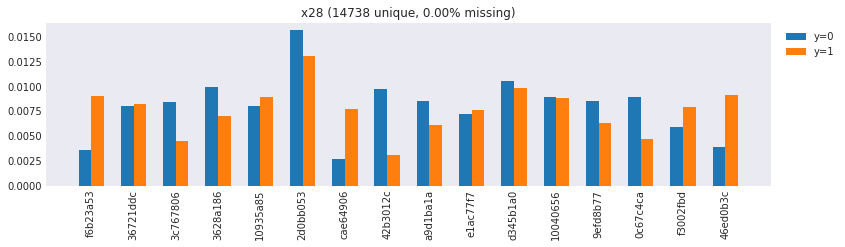

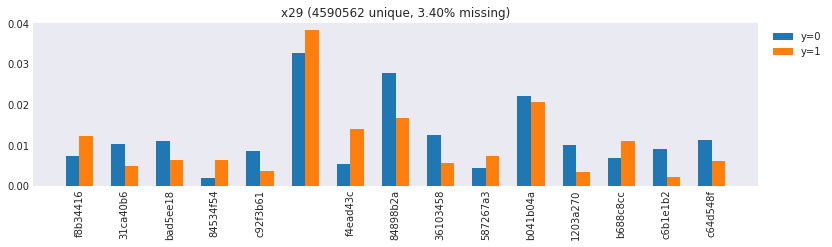

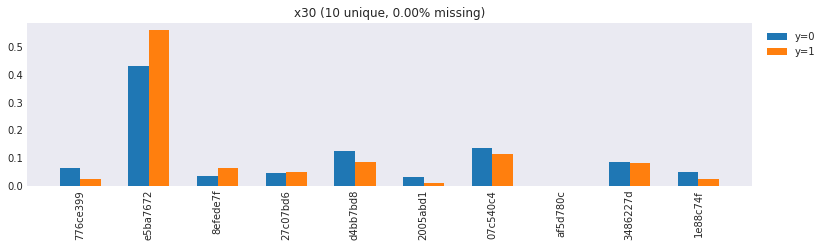

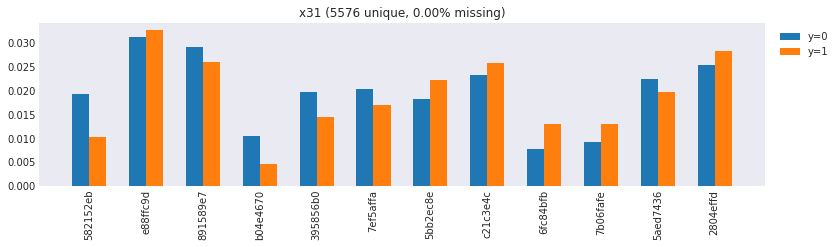

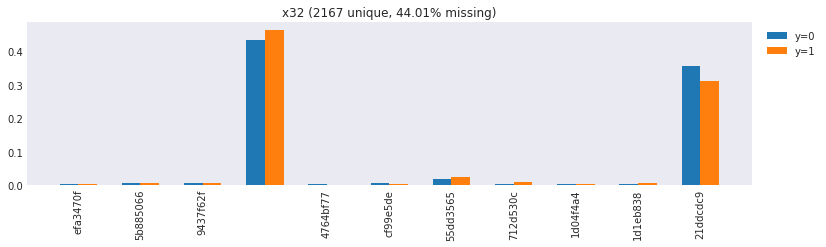

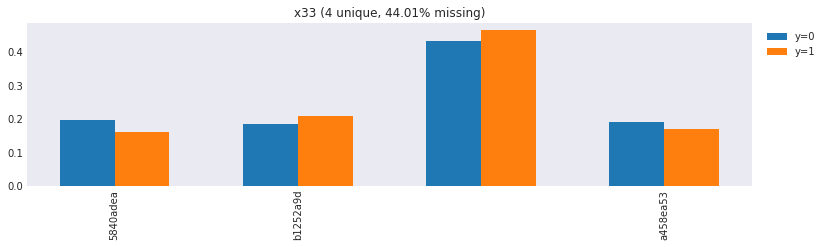

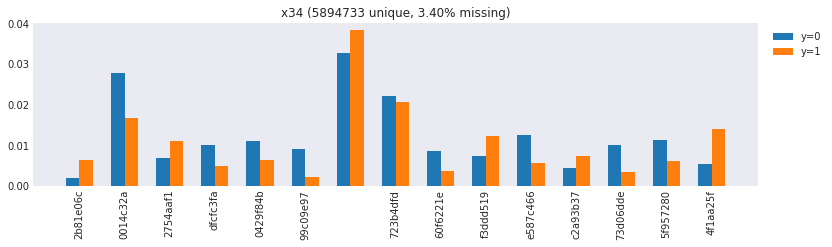

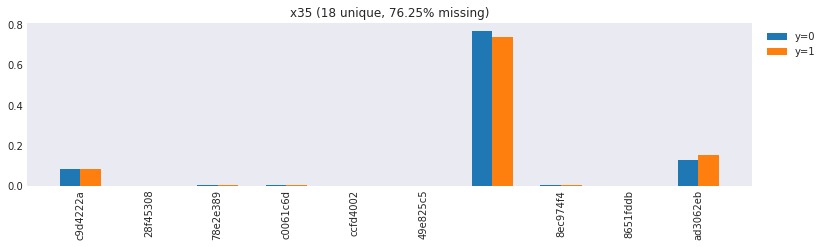

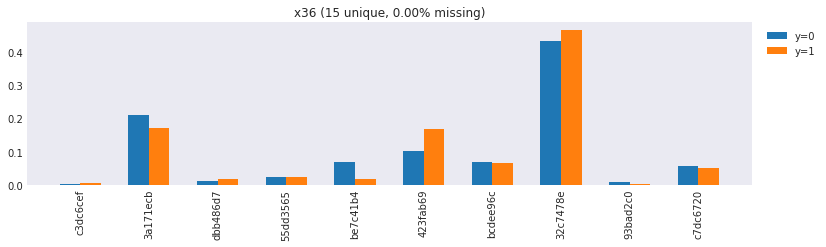

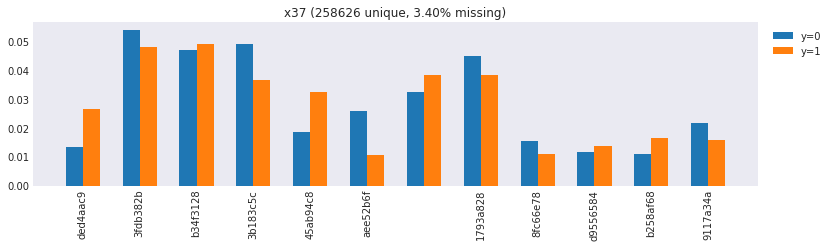

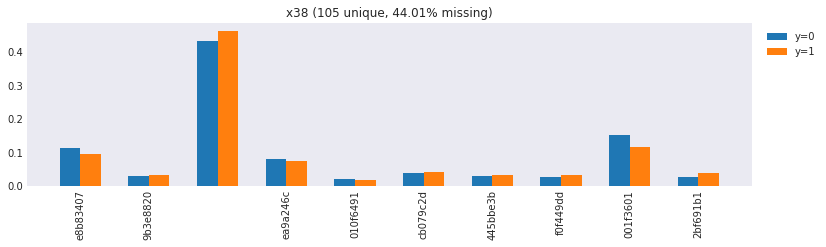

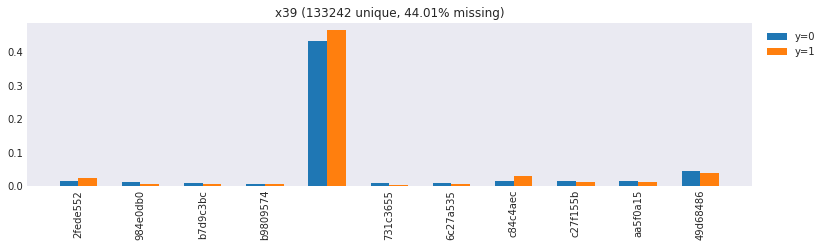

In [14]:
for feature in CATEGORICAL_FEATURES:

    #find the feature's value frequencies for class 0
    values_0_list = trainDF_0.groupBy(feature).agg({"*": "count"})
    values_0_rdd = values_0_list.rdd.map(lambda x: (x[0], (x[1], 0)))

    #find the feature's value frequencies for class 1
    values_1_list = trainDF_1.groupBy(feature).agg({"*": "count"})
    values_1_rdd = values_1_list.rdd.map(lambda x: (x[0], (0, x[1])))

    #concatenate the class 0 and class 1 value frequencies
    all_values = sc.union([values_0_rdd, values_1_rdd]).reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1]))
    all_values = all_values.map(lambda x: (x[0], x[1][0], x[1][1]))

    #find the top 10 features for each class
    top_0 = all_values.takeOrdered(10, lambda x: -x[1])
    top_1 = all_values.takeOrdered(10, lambda x: -x[2])
    top_both = pd.DataFrame(list(set(top_0)|set(top_1)))
    top_both.set_index(0, inplace=True)
    top_both.columns = ["y=0","y=1"]

    #create a grouped barplot
    bar_width = 0.3
    bar_loc = np.arange(len(top_both.index))+1
    fig, ax = plt.subplots(figsize=(13, 3))
    plt.bar(bar_loc, top_both["y=0"].values/train_count_0, label="y=0", width=bar_width)
    plt.bar(bar_loc+bar_width, top_both["y=1"].values/train_count_1, label="y=1", width=bar_width)
    ax.set_xticks(bar_loc + bar_width / 2)
    ax.set_xticklabels(top_both.index)
    ax.legend(loc="upper right", bbox_to_anchor=(1.1, 1))
    plt.xticks(rotation=90)

    #find number of unique and missing values for the feature
    num_unique = all_values.count()
    missing = all_values.filter(lambda x: x[0]=="").collect()
    if missing == []:
        missing_0, missing_1 = 0, 0
    else:
        missing_0, missing_1 = missing[0][1], missing[0][2]
    percent_missing = ((missing_0 + missing_1)/train_count) * 100
    plt.title("{} ({} unique, {:0.2f}% missing)".format(feature, num_unique, percent_missing))
    plt.show()

From the analysis above, we conclude that we should exclude variables x14, x18, and x21 as they provide no information to differentiate between the two classes

In order to preserve some aspect of this data, we can instead keep the top K values for these specific columns in order to continue to use them in our model.  We will perform this transformation for these specific variables.

## 3.d. Numeric Variables EDA

Next, we looked into the numeric variable data. All but feature x2 took on positive values. A few of the columns have a significant amount of missing values, such as x1, x10, and x12. In comparison to the categorical data, the number of unique values were generally less. It also appeared that the values took on the form of integers rather than float. Because of this, we speculated that perhaps the numeric values may actually be non-ordinal and categorical.

In [16]:
int_summary = trainDF.select(INTEGER_FEATURES).describe().toPandas()
int_summary.set_index("summary", inplace=True, drop=True)
int_summary.T

summary,count,mean,stddev,min,max
y,36668262,0.2562327606364327,0.43655187344736995,0.0,1.0
x1,20035252,3.5031570853214125,9.462578314273099,0.0,5775.0
x2,36668262,105.8343438530029,391.938244881369,-3.0,257675.0
x3,28795809,26.90791805849247,397.978129028301,0.0,65535.0
x4,28718788,7.322204857670178,8.794009401800523,0.0,933.0
x5,35721941,18541.787032989054,69434.72237810925,0.0,2.3159456E7
x6,28466947,116.1169930516258,384.64866776459604,0.0,431037.0
x7,35082528,16.332403240724272,66.14282854870781,0.0,56311.0
x8,36650049,12.517627711766497,16.74889866878638,0.0,5974.0
x9,35082528,106.11065032143635,220.35083512936538,0.0,29019.0


In [20]:
#find percentage of missing values for numeric features
for feature in INTEGER_FEATURES:
    num_unique = trainDF.select(feature).distinct().count()
    percent_missing = (trainDF.filter(F.isnull(feature)).count() / train_count )*100
    print("{} has {} unique values and {:0.2f}% missing values".format(feature, num_unique, percent_missing))

y has 2 unique values and 0.00% missing values
x1 has 623 unique values and 45.36% missing values
x2 has 8945 unique values and 0.00% missing values
x3 has 13041 unique values and 21.47% missing values
x4 has 466 unique values and 21.68% missing values
x5 has 443659 unique values and 2.58% missing values
x6 has 10932 unique values and 22.37% missing values
x7 has 3929 unique values and 4.32% missing values
x8 has 1260 unique values and 0.05% missing values
x9 has 6944 unique values and 4.32% missing values
x10 has 13 unique values and 45.36% missing values
x11 has 165 unique values and 4.32% missing values
x12 has 386 unique values and 76.51% missing values
x13 has 1250 unique values and 21.68% missing values


In [17]:
sample = trainDF.sample(False, 0.001, seed=1234).toPandas() # Approximately 40000 records

In [19]:
sample[INTEGER_FEATURES].head(20)

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13
0,0.0,NaN,-2.0,12.0,3.0,7329.0,81.0,59.0,20.0,191.0,NaN,5.0,0.0,8.0
1,0.0,NaN,-2.0,165.0,20.0,17850.0,202.0,4.0,22.0,67.0,NaN,1.0,NaN,20.0
2,0.0,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
4,0.0,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
5,0.0,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN
6,0.0,NaN,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,4.0,NaN,0.0,NaN,NaN
7,0.0,NaN,-1.0,NaN,NaN,NaN,NaN,0.0,1.0,14.0,NaN,0.0,NaN,NaN
8,0.0,NaN,-1.0,NaN,NaN,NaN,NaN,0.0,2.0,3.0,NaN,0.0,NaN,NaN
9,0.0,NaN,-1.0,NaN,NaN,NaN,NaN,0.0,5.0,5.0,NaN,0.0,NaN,NaN


Taking a sample of the training data set, we plotted the distribution of numeric features on a log scale. Some of the features do not appear to have differing distributions for each class, for example, x2, x8, x,9 and x10. 


Text(0.5, 0.9, 'Individual Features vs. Click Through')

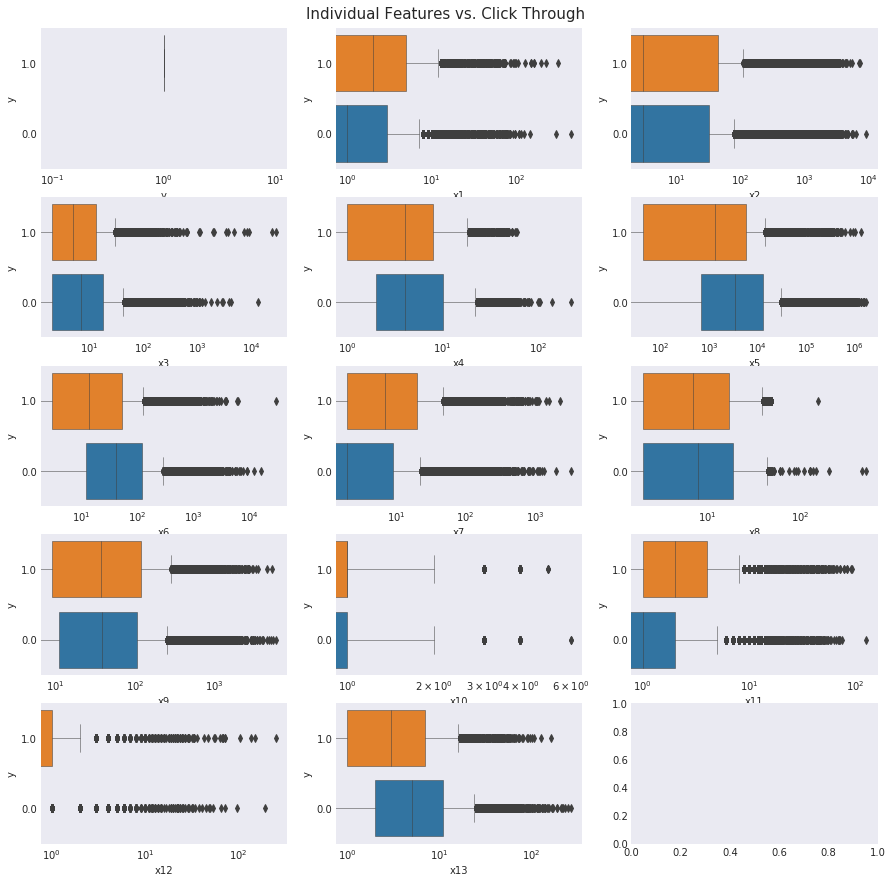

In [23]:
# Plotting each individual integer feature vs. click through rates
fig, ax_grid = plt.subplots(5, 3, figsize=(15,15))
y = sample['y']
for idx, feature in enumerate(INTEGER_FEATURES):
    x = sample[feature]
    box = sns.boxplot(x, y, ax=ax_grid[idx//3][idx%3], orient='h', linewidth=.5)
    ax_grid[idx//3][idx%3].invert_yaxis()
    box.set(xscale="log")
fig.suptitle("Individual Features vs. Click Through", fontsize=15, y=0.9)
#plt.show()

We also looked at the correlations between the numeric features, as an assumption for logistic regression is that there is no multicollinearity between independent features. Based on the graphic below, we see that a number of features are correlated with one another.  However, we accept that this is coincidence because of our assumption that the values do not display ordinality.  From this, we can assume that there is no multi-collinearity when using logistic regression.

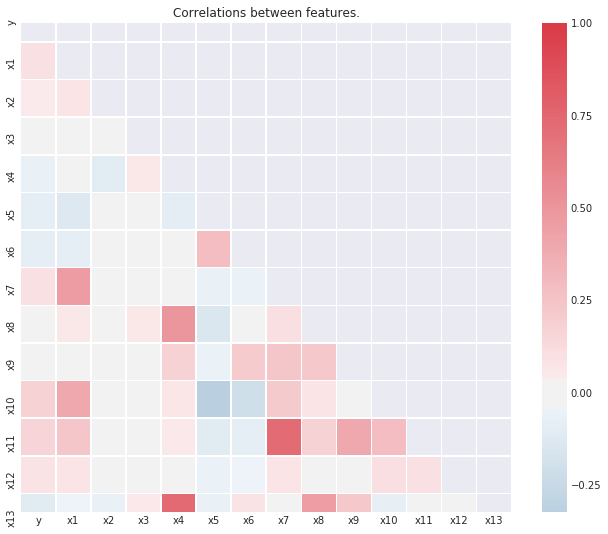

In [24]:
# plot heatmap for correlations matrix - RUN THIS CELL AS IS
corr = sample[INTEGER_FEATURES].corr()
fig, ax = plt.subplots(figsize=(11, 9))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.5)
plt.title("Correlations between features.")
plt.show()

From the above analysis we can see that although there are 40 million records, there are actually very few numeric values and they are all shown to be integers.  From this we may conclude that the data is not actually ordinal but that these also represent distinct categorical features.  We can go ahead and convert these integer features into categorical features as this will likely improve our algorithm by eliminating any dependence in the model to interpreting these values as having ordinality.

### Convert Numeric To Categorical Features

After converting the numeric data into categorical features, as well as filling in missing values with a blank string, we take a look at the value distributions for each class, as we had done earlier with the categorical features.

In [10]:
# Filling n/a values for processing
for feature in INTEGER_FEATURES[1:]:
    trainDF = trainDF.withColumn(feature, trainDF[feature].cast(StringType()))
    trainDF = trainDF.fillna({feature:''})
    
    validDF = validDF.withColumn(feature, validDF[feature].cast(StringType()))
    validDF = validDF.fillna({feature:''})
    
    testDF = testDF.withColumn(feature, testDF[feature].cast(StringType()))
    testDF = testDF.fillna({feature:''})

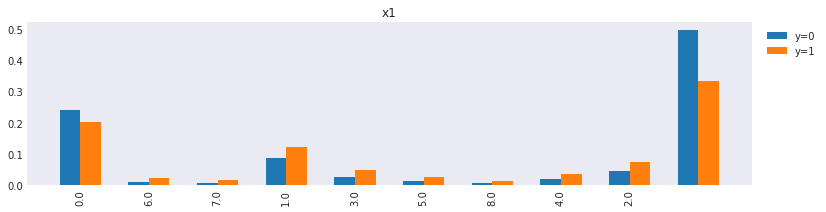

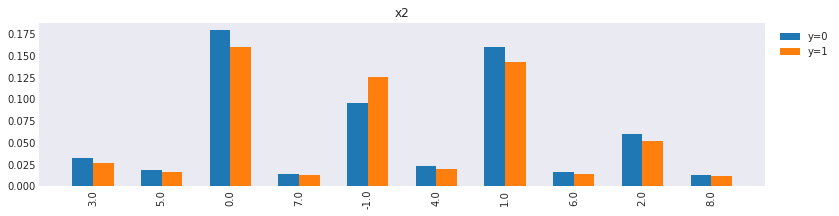

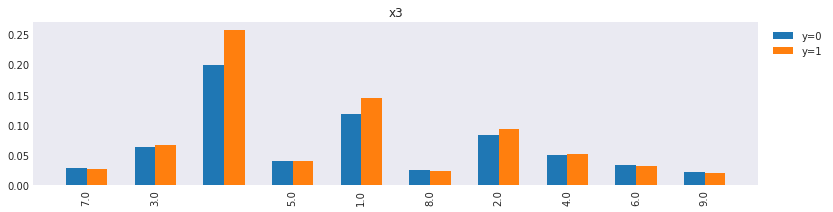

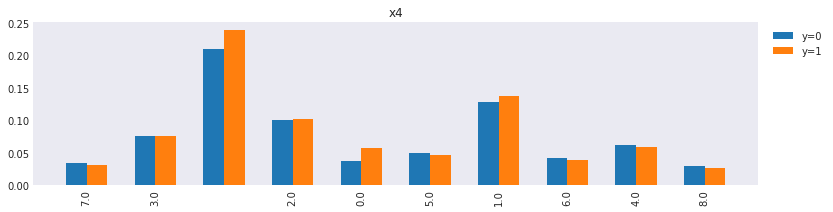

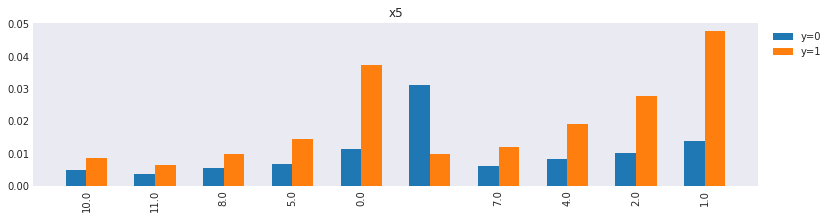

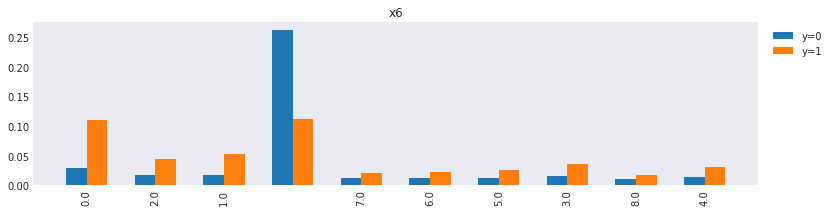

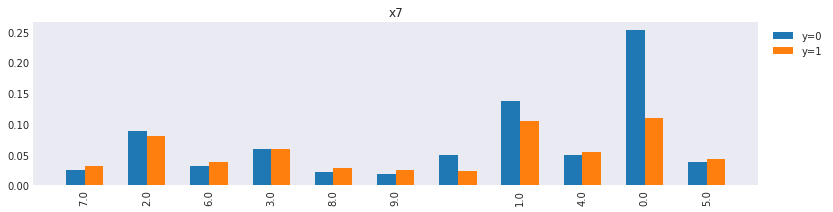

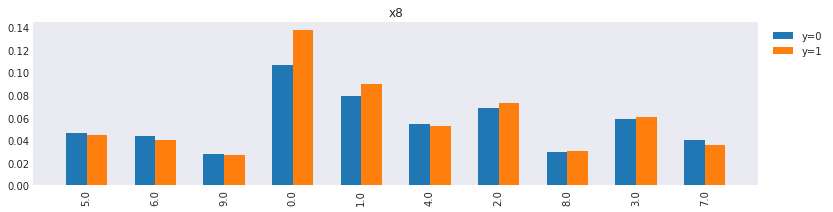

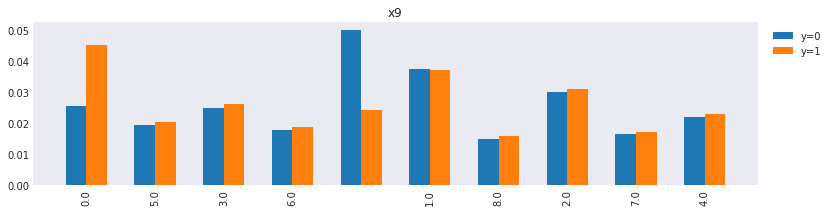

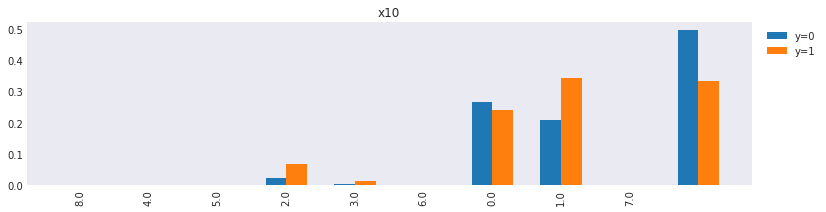

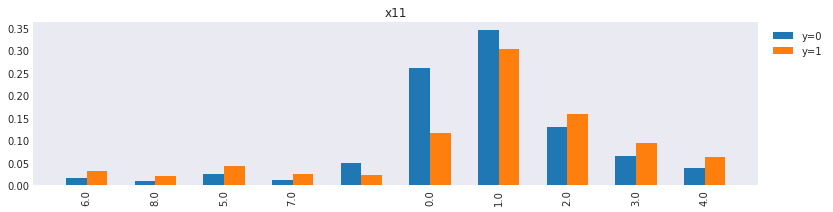

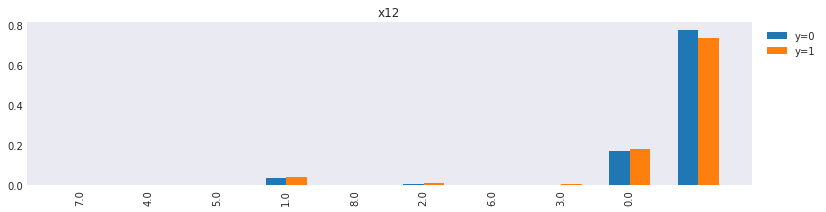

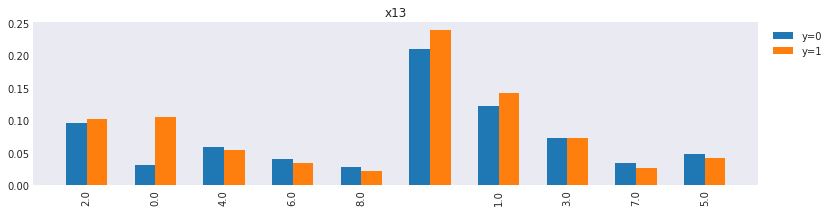

In [13]:
for feature in INTEGER_FEATURES[1:]:

    #find the feature's value frequencies for class 0
    values_0_list = trainDF_0.groupBy(feature).agg({"*": "count"})
    values_0_rdd = values_0_list.rdd.map(lambda x: (x[0], (x[1], 0)))

    #find the feature's value frequencies for class 1
    values_1_list = trainDF_1.groupBy(feature).agg({"*": "count"})
    values_1_rdd = values_1_list.rdd.map(lambda x: (x[0], (0, x[1])))

    #concatenate the class 0 and class 1 value frequencies
    all_values = sc.union([values_0_rdd, values_1_rdd]).reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1]))
    all_values = all_values.map(lambda x: (x[0], x[1][0], x[1][1]))

    #find the top 10 features for each class
    top_0 = all_values.takeOrdered(10, lambda x: -x[1])
    top_1 = all_values.takeOrdered(10, lambda x: -x[2])
    top_both = pd.DataFrame(list(set(top_0)|set(top_1)))
    top_both.set_index(0, inplace=True)
    top_both.columns = ["y=0","y=1"]

    #create a grouped barplot
    bar_width = 0.3
    bar_loc = np.arange(len(top_both.index))+1
    fig, ax = plt.subplots(figsize=(13, 3))
    plt.bar(bar_loc, top_both["y=0"].values/train_count_0, label="y=0", width=bar_width)
    plt.bar(bar_loc+bar_width, top_both["y=1"].values/train_count_1, label="y=1", width=bar_width)
    ax.set_xticks(bar_loc + bar_width / 2)
    ax.set_xticklabels(top_both.index)
    ax.legend(loc="upper right", bbox_to_anchor=(1.1, 1))
    plt.xticks(rotation=90)
    plt.title(feature)
    plt.show()

From the above analysis we see that we can likely include all of our previously numeric categories as we can see that there are distribution differences between the various classes.

## 3.e. Reduction of Categories

After converting the numeric features to categorical features, we now have a dataset comprised entirely of categorical data. Based on the EDA that we performed above, we decided to drop x14, x18, and x21 as they did not seem to have any differences in distribution for the top 10 values for each class.

In [25]:
CATEGORICAL_FEATURES = INTEGER_FEATURES + CATEGORICAL_FEATURES

In [26]:
# We will track which features to eliminate from our dataframe
featuresToDrop = set()
featuresToDrop.add('x14')
featuresToDrop.add('x18')
featuresToDrop.add('x21')

Because we have seen that some features have a high number of unique values, we decided to only use the top 10,000 most common values for those features that have too many values. If we had kept all the values, this may become too computationally expensive during one hot encoding and would provide little to no benefit as those values do not appear in the data very often and most of the column would end up too sparse with many 0’s. In the function keepTopK, we replace any value that is not in the top 10,000 most common values for the given feature with the string “RECODED”. Essentially we are combining all of these less commonly used values into its own category.

Based on our EDA, we identified 7 features with >10,000 unique values that would undergo this preprocessing: x5, x16, x17, x25, x29, x34, and x37.

In [27]:
def keepTopK(df, dfvalid, dftest, K, categoricalColumnstoImpute):
    '''This function will take the dataframes and return the same dataframes with just the
    the top k categorical values.
    '''
    
    for col in categoricalColumnstoImpute:
        mostCommon = df.select(col).groupby(col).count()\
                            .orderBy('count', ascending=False) \
                            .limit(K).collect()
            
        mostCommonSet = set([x[0] for x in mostCommon])
               
        df = df.withColumn(col, F.when(~df[col].isin(mostCommonSet), "RECODED").otherwise(df[col]))

        dfvalid = dfvalid.withColumn(col, F.when(~dfvalid[col].isin(mostCommonSet), "RECODED") \
                        .otherwise(dfvalid[col]))        
        
        dftest = dftest.withColumn(col, F.when(~dftest[col].isin(mostCommonSet), "RECODED") \
                        .otherwise(dftest[col]))
    
    print("Successfully Recoded Top K Categorical Values")
    
    return (df, dfvalid, dftest)

In [28]:
# Apply the top k categorical values to the current dataframes.
start = time.time()
trainDF, validDF, testDF = keepTopK(trainDF, validDF, testDF, 10000, ['x5', 'x16', 'x17', 'x25', 'x29', 'x34', 'x37']) # Select 10,000 top categories
print(f"\n... Executed in {time.time() - start} seconds")

Successfully Recoded Top K Categorical Values

... Executed in 633.0578525066376 seconds


In [29]:
# Count Number of Unique Values
start = time.time()
distinct = []
for col in CATEGORICAL_FEATURES:
    distinct.append(set(trainDF.select(col).distinct().rdd.map(lambda x: x[0]).collect()))
print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 1519.3760287761688 seconds


To confirm we have executed the recoding correctly, we go back and check the number of unique values for our data set. The 10,001th unique value is the new recoded category.

In [30]:
# For EDA, show us the unique values for each categorical variable
for item, number in zip(CATEGORICAL_FEATURES, distinct):
    print(f"Feature: {item} had {len(number)} unique values")

Feature: y had 2 unique values
Feature: x1 had 623 unique values
Feature: x2 had 8945 unique values
Feature: x3 had 13041 unique values
Feature: x4 had 466 unique values
Feature: x5 had 10001 unique values
Feature: x6 had 10932 unique values
Feature: x7 had 3929 unique values
Feature: x8 had 1260 unique values
Feature: x9 had 6944 unique values
Feature: x10 had 13 unique values
Feature: x11 had 165 unique values
Feature: x12 had 386 unique values
Feature: x13 had 1250 unique values
Feature: x14 had 1460 unique values
Feature: x15 had 580 unique values
Feature: x16 had 10001 unique values
Feature: x17 had 10001 unique values
Feature: x18 had 305 unique values
Feature: x19 had 24 unique values
Feature: x20 had 12482 unique values
Feature: x21 had 633 unique values
Feature: x22 had 3 unique values
Feature: x23 had 88969 unique values
Feature: x24 had 5645 unique values
Feature: x25 had 10001 unique values
Feature: x26 had 3193 unique values
Feature: x27 had 27 unique values
Feature: x28 h

In [31]:
distinctDict = dict((k, v) for k, v  in zip(CATEGORICAL_FEATURES, distinct))

## 3.f. Impute Missing Values

Here we will impute missing values when appropriate.  Since we have converted our numeric values to categorical, we do not need to worry about imputing the mean.  In the case of categorical features, we will impute the most common instance for that categorical feature.  If the most common feature is a missing value, we will create a new "empty" variable that will hold the place for this circumstance.  In the case that the test data has unseen categorical values, we will replace those with the empty string and allow the impute function to fill these values.

In [32]:
def imputeValues(df, dfvalid, dftest):
    '''This function will impute the categorical variables and return back the same dataframe with the
    imputed values. It will also ensure that there are no missing values.
    '''
    
    categoricalColumnstoImpute = CATEGORICAL_FEATURES[1:]
    
    # Impute categorical features
    for col in categoricalColumnstoImpute:
        mostCommon = df.select(col).groupby(col).count()\
                            .orderBy('count', ascending=False) \
                            .limit(1).collect()[0][0]
        if mostCommon == "":
            mostCommon = "EMPTY"
        
        print(f"Column {col} has most common {mostCommon}")
        
        df = df.withColumn(col, F.when((df[col].isNull() | (df[col] == '')), mostCommon) \
                                .otherwise(df[col]))
        
        dfvalid = dfvalid.withColumn(col, F.when((dfvalid[col].isNull() | (dfvalid[col] == '') | (~dfvalid[col].isin(distinctDict[col]))), mostCommon) \
                        .otherwise(dfvalid[col]))
        
        dftest = dftest.withColumn(col, F.when((dftest[col].isNull() | (dftest[col] == '') | (~dftest[col].isin(distinctDict[col]))), mostCommon) \
                        .otherwise(dftest[col]))
    print("Successfully Imputed Categorical Values")
    
    # Assure there is no missing values
    for col in categoricalColumnstoImpute:
        assert df.filter(df[col].isNull()).count() == 0, f"Column {col} contains NULL value(s)"
        assert df.filter(df[col] == '').count() == 0, f"Column {col} contains empty string(s)"

        assert dfvalid.filter(dfvalid[col].isNull()).count() == 0, f"Column {col} contains NULL value(s)"
        assert dfvalid.filter(dfvalid[col] == '').count() == 0, f"Column {col} contains empty string(s)"
        
        assert dftest.filter(dftest[col].isNull()).count() == 0, f"Column {col} contains NULL value(s)"
        assert dftest.filter(dftest[col] == '').count() == 0, f"Column {col} contains empty string(s)"
    
    print("Successfully Imputed All Values and Passed Tests")
    return (df, dfvalid, dftest)

In [33]:
# Apply the imputeValues function to our dataframes
start = time.time()
trainDF, validDF, testDF = imputeValues(trainDF, validDF, testDF)
print(f"\n... Executed in {time.time() - start} seconds")

Column x1 has most common EMPTY
Column x2 has most common 0.0
Column x3 has most common EMPTY
Column x4 has most common EMPTY
Column x5 has most common RECODED
Column x6 has most common EMPTY
Column x7 has most common 0.0
Column x8 has most common 0.0
Column x9 has most common EMPTY
Column x10 has most common EMPTY
Column x11 has most common 1.0
Column x12 has most common EMPTY
Column x13 has most common EMPTY
Column x14 has most common 05db9164
Column x15 has most common 38a947a1
Column x16 has most common RECODED
Column x17 has most common RECODED
Column x18 has most common 25c83c98
Column x19 has most common 7e0ccccf
Column x20 has most common 1c86e0eb
Column x21 has most common 0b153874
Column x22 has most common a73ee510
Column x23 has most common 3b08e48b
Column x24 has most common 755e4a50
Column x25 has most common RECODED
Column x26 has most common 5978055e
Column x27 has most common b28479f6
Column x28 has most common 2d0bb053
Column x29 has most common RECODED
Column x30 has

We then write these new files to parquet so that we do not need to execute these commands in our future analysis in the case of our machine crashing.

In [34]:
start = time.time()
trainDF.write.mode('overwrite').parquet('trainImputed.parquet')
validDF.write.mode('overwrite').parquet('validImputed.parquet')
testDF.write.mode('overwrite').parquet('testImputed.parquet')
print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 378.27341175079346 seconds


In [35]:
start = time.time()
trainDF = sqlContext.read.parquet('trainImputed.parquet')
validDF = sqlContext.read.parquet('validImputed.parquet')
testDF = sqlContext.read.parquet('testImputed.parquet')
print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 0.26279735565185547 seconds


## 3.g. Apply One Hot Encoding and Scale Our Features for Use With Regularization

In general, it's difficult to accurately train model with categorical variables.  Machine learning algorithms also cannot work with categorical data directly, so we will convert these into numerical representations using One Hot Encoding method. Essentially, a new column is created for each "value" in the categorical variable and a binary result (0 or 1) is provided for each row. 

We used the OneHotEncoder from the pyspark ml library. We used the default behavior of the transformer, which will actually omit the last category for each feature, as the information has already been captured by the previous columns and to prevent the one hot encoded columns of each feature from becoming linearly dependent as they sum up to 1. Based on the documentation, there is also a newer implementation of the transformer, OneHotEncoderEstimator, that is able to handle values in the validation or test set that were not present in the training set. However, we used OneHotEncoder and did not run into this issue.

After one hot encoding, we apply a MaxAbsScaler to the data. This step is not necessarily needed for our particular data set since we have already converted the categorical data that has been one hot encoded to only have 0 and 1. However, if numeric data is added to the data set in the feature, then including a scaler is necessary, especially for regularization during logistic regression.

MaxAbsScaler was chosen because it preserves the sparsity and values that are 0 are able to remain at 0. Using sparse representation allows us to save memory, which is especially important with such a large dataset.

In [36]:
OHE_CATEGORICAL_FEATURES =  set(CATEGORICAL_FEATURES[1:]) - featuresToDrop # Remaining Categorical Features for the One hot encoding, exclude 'y'

In [37]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, MaxAbsScaler, VectorAssembler
from pyspark.ml import Pipeline

def makePreprocessor(df):
    '''Takes a dataframe and pre-processes it via one hot encoding'''
    
    # String Indexing for categorical features
    indexers = [StringIndexer(inputCol=col, 
                              outputCol="{}_idx".format(col)) \
                              for col in OHE_CATEGORICAL_FEATURES]
    
    # One-hot encoding for categorical features
    encoders = [OneHotEncoder(inputCol="{}_idx".format(col), 
                              outputCol="{}_oh".format(col)) \
                              for col in OHE_CATEGORICAL_FEATURES]

    # Concatenate Feature Columns
    assembler = VectorAssembler(inputCols = ["{}_oh".format(col) for col in OHE_CATEGORICAL_FEATURES], outputCol = "scaledFeatures")
    
    # Scale Features
    scaler = MaxAbsScaler(inputCol='scaledFeatures', outputCol='features')
    
    preprocessor = Pipeline(stages = indexers + encoders + [assembler, scaler]).fit(df)

    return preprocessor

In [38]:
start = time.time()
# Pre-Process All Training Data
preprocessor = makePreprocessor(trainDF)   
print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 282.9363098144531 seconds


In [39]:
start = time.time()
trainDF = preprocessor.transform(trainDF)
print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 2.307182788848877 seconds


In [40]:
start = time.time()
validDF = preprocessor.transform(validDF)
print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 2.2572078704833984 seconds


In [41]:
start = time.time()
testDF = preprocessor.transform(testDF)
print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 2.362525463104248 seconds


We will now drop all the features except for what we will use in our model.

In [42]:
OHE_CATEGORICAL_FEATURES_idx = [f"{col}_idx" for col in OHE_CATEGORICAL_FEATURES]
OHE_CATEGORICAL_FEATURES_oh = [f"{col}_oh" for col in OHE_CATEGORICAL_FEATURES]

featuresToDrop = featuresToDrop.union(set(OHE_CATEGORICAL_FEATURES))\
                                .union(set(OHE_CATEGORICAL_FEATURES_idx))\
                                .union(set(OHE_CATEGORICAL_FEATURES_oh))
featuresToDrop.add('scaledFeatures')
featuresToDrop = featuresToDrop.union(set(CATEGORICAL_FEATURES[1:]))

In [43]:
# Drop the Feature Columns We Will Not Use
trainDF = trainDF.select([c for c in trainDF.columns if c not in featuresToDrop])
validDF = validDF.select([c for c in validDF.columns if c not in featuresToDrop])
testDF = testDF.select([c for c in testDF.columns if c not in featuresToDrop])

Now we can write to a parquet File so that we should only need to work on our model now.

In [44]:
start = time.time()
trainDF.write.mode('overwrite').parquet('train_for_model.parquet')
validDF.write.mode('overwrite').parquet('valid_for_model.parquet')
testDF.write.mode('overwrite').parquet('test_for_model.parquet')
print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 342.07127380371094 seconds


# 4. Algorithm Implementation and Evaluation

After EDA, we took a three-method approach. First, we ran a single fold Logistic Regression in order to establish a baseline. Then we did a K-fold Logistic Regression, where we set k equal to 10. Using the K-fold cross validation, we are able to search different parameters such as the regularization parameter and elastic net parameter. We used area under the precision recall curve to select for the best performing model. Finally, we applied class balancing techniques to the K-fold Logistic Regression to account for the unbalanced classes that we discovered in our EDA. 

We also tried using Random Forest and Gradient Boosted Trees for comparison to our Logistic Regression models. Then, we submitted our models to Kaggle to see how we perform on the leaderboard.

## 4.a. Single Fold Logistic Regression

In [45]:
start = time.time()
trainDF = sqlContext.read.parquet('train_for_model.parquet')
validDF = sqlContext.read.parquet('valid_for_model.parquet')
testDF = sqlContext.read.parquet('test_for_model.parquet')
print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 0.22734999656677246 seconds


In [46]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [47]:
start = time.time()
lr = LogisticRegression(featuresCol = 'features', labelCol='y', maxIter=10000, regParam=5.0)
lr_model = lr.fit(trainDF)
lr_train_predictions = lr_model.transform(trainDF)
lr_valid_predictions = lr_model.transform(validDF)
lr_test_predictions = lr_model.transform(testDF)
print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 369.5195915699005 seconds


In [48]:
start = time.time()
lr_evaluator = BinaryClassificationEvaluator(labelCol="y", rawPredictionCol="prediction",metricName="areaUnderPR")

trainAUPR = lr_evaluator.evaluate(lr_train_predictions)
validAUPR = lr_evaluator.evaluate(lr_valid_predictions)
print(f"Area Under Precision Recall Curve on Train data = {trainAUPR}")
print(f"Area Under Precision Recall Curve on Validation data = {validAUPR}")
print(f"\n... Executed in {time.time() - start} seconds")

Area Under Precision Recall Curve on Train data = 0.6146150968284259
Area Under Precision Recall Curve on Validation data = 0.6124961502758849

... Executed in 57.795005798339844 seconds


In [49]:
start = time.time()
lr_model.write().overwrite().save("lr_best_model")
print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 0.6521258354187012 seconds


Our results met our expectation as this was a baseline model, but we hope to improve with with K-Fold Cross Validation.

## 4.b. K-Fold Cross Validation for Logistic Regression

In [50]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.ml import Pipeline

In [51]:
start = time.time()
lr = LogisticRegression(featuresCol = 'features', labelCol='y', maxIter=100)
    
# Train the 10-fold Cross Validator
cvModel = CrossValidator(estimator=Pipeline(stages = [lr]),
            estimatorParamMaps=ParamGridBuilder() \
                                .addGrid(lr.regParam, [1.5, 1.0, 0.5]) \
                                .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
                                .build(),
            evaluator=BinaryClassificationEvaluator(labelCol="y", rawPredictionCol="prediction",metricName="areaUnderPR"),numFolds=10).fit(trainDF)

print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 17242.62928891182 seconds


In [52]:
regParam = cvModel.bestModel.stages[-1]._java_obj.getRegParam()
maxIter = cvModel.bestModel.stages[-1]._java_obj.getMaxIter()
elasticNetParam = cvModel.bestModel.stages[-1]._java_obj.getElasticNetParam()
print("Best Model Parameters:")
print(f"Reg Param: {regParam}, Max Iterations: {maxIter}, Elastic Net Param: {elasticNetParam}")

Best Model Parameters:
Reg Param: 1.5, Max Iterations: 100, Elastic Net Param: 0.0


After evaluation of our grid search, we see that our best performing model makes use of a regularization parameter of 1.5, that is, at the highest range of our evaluated grid.  Additionally, we have an elastic net parameter of 0.  The elastic net is an additional parameter that can allow for a linear combination of both L1 and L2 regularization.  Because the parameter is best at 0, we choose to only use the L2 regularization term for the remainder of our model.

In [53]:
start = time.time()
lr = LogisticRegression(featuresCol = 'features', labelCol='y', maxIter=100)
    
# Train the 10-fold Cross Validator
cvModel = CrossValidator(estimator=Pipeline(stages = [lr]),
            estimatorParamMaps=ParamGridBuilder() \
                                .addGrid(lr.regParam, [6.0, 5.0, 4.0, 3.0, 2.0]) \
                                .build(),
            evaluator=BinaryClassificationEvaluator(labelCol="y", rawPredictionCol="prediction",metricName="areaUnderPR"),numFolds=10).fit(trainDF)

print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 18536.98310494423 seconds


In [54]:
regParam = cvModel.bestModel.stages[-1]._java_obj.getRegParam()
maxIter = cvModel.bestModel.stages[-1]._java_obj.getMaxIter()
elasticNetParam = cvModel.bestModel.stages[-1]._java_obj.getElasticNetParam()
print("Best Model Parameters:")
print(f"Reg Param: {regParam}, Max Iterations: {maxIter}, Elastic Net Param: {elasticNetParam}")

Best Model Parameters:
Reg Param: 5.0, Max Iterations: 100, Elastic Net Param: 0.0


After evaluation of the grid search over the parameter space for the regularization term, we can see the the best performance occurs for a regularization parameter of 5.

In [55]:
start = time.time()
cvModel.bestModel.write().overwrite().save("cv_best_model")
print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 0.7969648838043213 seconds


### Model Evaluation with Selected Metrics

In [56]:
start = time.time()
trainPredsAndLabels = cvModel.transform(trainDF)
validPredsAndLabels = cvModel.transform(validDF)
testPredsAndLabels = cvModel.transform(testDF)
print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 0.06529498100280762 seconds


In [57]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics

def evaluateModel(predictionAndLabels):
    '''This function will evaluate our model for the area under ROC, area under PR, show a confusion matrix,
    and calculate precision, recall, and F1-score. It will then return the results.    
    '''
    
    resultsDict = dict()
    
    # Area Under ROC
    evaluator = BinaryClassificationEvaluator(labelCol="y", rawPredictionCol="prediction", metricName="areaUnderROC")
    areaUnderROC = evaluator.evaluate(predictionAndLabels)    
    print(f"Area under ROC = {areaUnderROC}")
    resultsDict['areaUnderROC'] = areaUnderROC

    # Area Under PR
    evaluator = BinaryClassificationEvaluator(labelCol="y", rawPredictionCol="prediction", metricName='areaUnderPR')
    areaUnderPR = evaluator.evaluate(predictionAndLabels)
    print(f"Area under PR = {areaUnderPR}")
    resultsDict['areaUnderPR'] = areaUnderPR

    # Metrics
    predictionRDD = predictionAndLabels.select(['y', 'prediction']) \
                            .rdd.map(lambda line: (line[1], line[0]))
    metrics = MulticlassMetrics(predictionRDD)

    # Confusion Matrix
    cm = metrics.confusionMatrix().toArray()
    resultsDict['cm'] = cm

    # Overall statistics
    precision = metrics.precision()
    resultsDict['precision'] = precision
    
    recall = metrics.recall()
    resultsDict['recall'] = recall
    
    fscore = metrics.fMeasure()
    resultsDict['F Score'] = fscore
        
    print(f"Precision: {precision}, Recall: {recall}, F Score: {fscore}")
            
    # Statistics by class
    labels = [0.0, 1.0]
    for label in sorted(labels):
        resultsDict[label] = {}
        resultsDict[label]['precision'] = metrics.precision(label)
        resultsDict[label]['recall'] = metrics.recall(label)
        resultsDict[label]['F1 Measure'] = metrics.fMeasure(label, beta=1.0)
        print(f"Class {label}: Precision: {resultsDict[label]['precision']}, Recall: {resultsDict[label]['recall']}, F Score: {resultsDict[label]['F1 Measure']}")

    return resultsDict

In [14]:
def plot_cm(cm,title):
    '''This function will plot a confusion matrix.'''
    sns.set(font_scale=1.4)
    cm_percent = (cm/cm.sum())*100
    labels = np.array([[str(np.round(x[0],2))+"%",str(np.round(x[1],2))+"%"] for x in (cm/cm.sum())*100])
    ax = sns.heatmap(cm_percent, annot=labels, fmt="")
    ax.set(xlabel='Prediction', ylabel='Truth', title=title)

In [59]:
start = time.time()
trainResultDict = evaluateModel(trainPredsAndLabels)
print(f"\n... Executed in {time.time() - start} seconds")

Area under ROC = 0.5000530223058309
Area under PR = 0.6146150968284259
Precision: 0.7437939109303844, Recall: 0.7437939109303844, F Score: 0.7437939109303844
Class 0.0: Precision: 0.7437874496539526, Recall: 0.9999989733304997, F Score: 0.8530708534329435
Class 1.0: Precision: 0.9729206963249516, Recall: 0.00010707128116215978, F Score: 0.00021411899822958069

... Executed in 374.2199547290802 seconds


After comparison of the K-fold model with the single fold model, we saw no improvement in the Area under the PR Curve, as both have a value of 0.615.  It appears that with a sufficiently large dataset, that there is no improvement with the use of K fold cross valdiation.

We also noticed that the majority of the predictions are in class 0. The class 1 recall and F-scores were very low. This may be due to the imbalanced data set as the majority (74.38%) of the observations belonged to class 0.

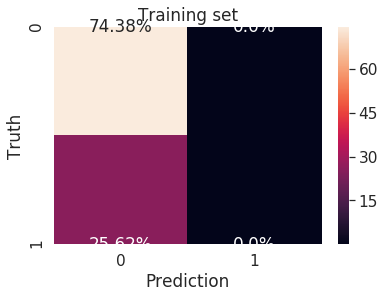

In [66]:
plot_cm(trainResultDict["cm"],"Training set")

In [61]:
start = time.time()
validResultDict = evaluateModel(validPredsAndLabels)
print(f"\n... Executed in {time.time() - start} seconds")

Area under ROC = 0.5000391376450419
Area under PR = 0.6124961502758849
Precision: 0.743833726453021, Recall: 0.743833726453021, F Score: 0.743833726453021
Class 0.0: Precision: 0.7438290183024441, Recall: 0.9999991205604609, F Score: 0.8530982469807168
Class 1.0: Precision: 0.96875, Recall: 7.915472962276388e-05, F Score: 0.0001582965251359563

... Executed in 90.66420841217041 seconds


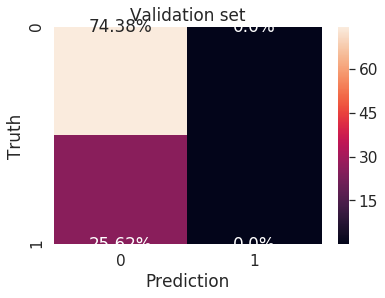

In [67]:
plot_cm(validResultDict["cm"],"Validation set")

### Plot Probabilities

Because logistic regression results in a probability between 0 and 1, we can also view the distribution of the probabilities for each class. We notice that the probability distributions are overlapping a fair amount. The threshold used as the decision boundary, 0.5, is plotted as well and shows that it is quite far to the right of the distribution.

In [63]:
def plot_prob(PredsAndLabels, threshold):
    prob_class0 = PredsAndLabels.where(F.col("y") == 0).select("probability").rdd.map(lambda x: x[0][1]).collect()
    prob_class1 = PredsAndLabels.where(F.col("y") == 1).select("probability").rdd.map(lambda x: x[0][1]).collect()
    bins = np.arange(0, 1, 0.025)
    plt.hist(prob_class0, bins=bins, density=True, alpha=0.7, label="y=0")
    plt.hist(prob_class1, bins=bins, density=True, alpha=0.7, label="y=1")
    plt.axvline(x=threshold, color='k')
    plt.title("Validation set prediction probability distribution")
    plt.legend()
    plt.show()

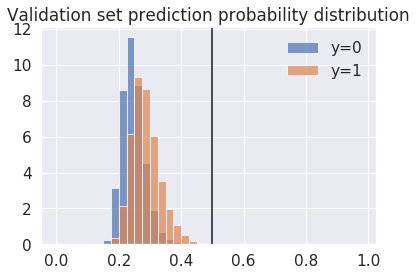

In [64]:
plot_prob(validPredsAndLabels, 0.5)

### Adjust Threshold

We can try adjusting the threshold such that we can call more predictions in class 1. We can measure the F-score at each threshold and select the threshold that has the maximum score. In this model, we find that the best threshold at 0.26 is almost half of the previous threshold.

In [75]:
trainingSummary = cvModel.bestModel.stages[-1].summary
fMeasure = trainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']).select('threshold').head()['threshold']
print("The best threshold by F-Measure is:",bestThreshold)

The best threshold by F-Measure is: 0.2626795691677175


In [77]:
validPredsAndLabels_BestThreshold = cvModel.bestModel.stages[-1].transform(validDF, {cvModel.bestModel.stages[-1].threshold: bestThreshold})

By reducing the threshold, we predict a lot more observations as class 1, in fact, a lot more wrong than correct. This is probably due to the fact that the probabilities predicted for each class strongly overlaps. We do observe that the area under the ROC curve has increased, though this measure may not be entirely suitable for our imbalanced data. On the other hand, the area under the precision recall curve had decreased, which is worse performing.

Depending on the cost of a false positive or a false negative, we may want to choose a threshold that the particular business is able to tolerate more. If the business does not mind placing many ads, knowing that many of the users predicted to click on the ad actually does not click on the ad, then they may want to go with the smaller threshold. If it costs a lot to place ads, and they want to be more sure that the ads shown are clicked on, then they may want to go with the larger threshold.  

In [78]:
start = time.time()
validBestThreshold_ResultDict = evaluateModel(validPredsAndLabels_BestThreshold)
print(f"\n... Executed in {time.time() - start} seconds")

Area under ROC = 0.6926870699574612
Area under PR = 0.41613027235515887
Precision: 0.7037384619326226, Recall: 0.7037384619326226, F Score: 0.7037384619326226
Class 0.0: Precision: 0.8629060304776245, Recall: 0.7153506318113508, F Score: 0.7822306584795151
Class 1.0: Precision: 0.44773335062340963, Recall: 0.6700235081035718, F Score: 0.536774823500212

... Executed in 88.79747009277344 seconds


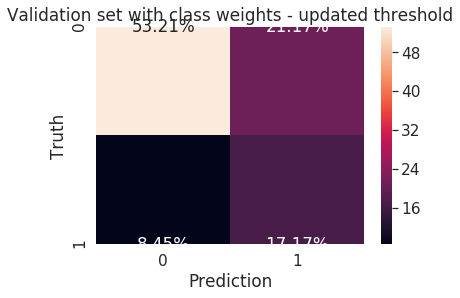

In [79]:
plot_cm(validBestThreshold_ResultDict["cm"],"Validation set with class weights - updated threshold")

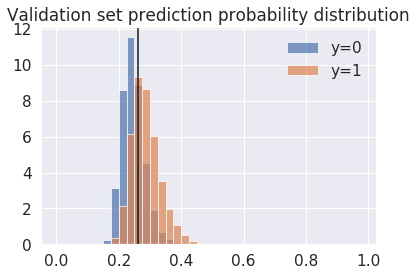

In [80]:
plot_prob(validPredsAndLabels_BestThreshold, bestThreshold)

### Visualize Precision & Recall Graphs

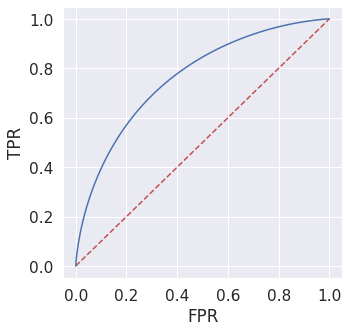


... Executed in 0.29901814460754395 seconds


In [81]:
start = time.time()
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(cvModel.bestModel.stages[-1].summary.roc.select('FPR').collect(),
         cvModel.bestModel.stages[-1].summary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()
print(f"\n... Executed in {time.time() - start} seconds")

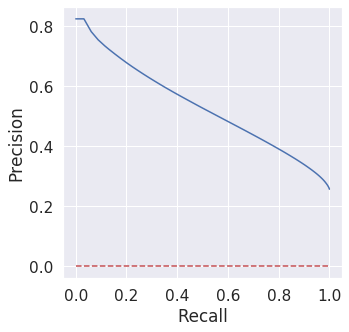


... Executed in 0.27295732498168945 seconds


In [82]:
start = time.time()
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 0], 'r--')
plt.plot(cvModel.bestModel.stages[-1].summary.pr.select('recall').collect(),
         cvModel.bestModel.stages[-1].summary.pr.select('precision').collect())
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()
print(f"\n... Executed in {time.time() - start} seconds")

Our results show great results for precision, recall, and f1-scoring which had varying interpretations to CTR for online advertisements.

## 4.c. K-Fold Cross Validation for Logistic Regression with Class Weights

Because our dataset is fairly imbalanced, we wanted to try to see if training with class weights could improve the model's performance. To do this, we calculate a balancing ratio which is the ratio of the majority class (class 0) to the total number of observations. Then we create a new column, classWeights, and assign the balancing ratio to the observations in the minority class, and 1 - balancing ratio to the majority class. This allows us to penalize the predictions that are incorrect for the minority class more strongly than the majority class.

In [83]:
#balancing ratio is the of the majority class
BalancingRatio = train_count_0/train_count
BalancingRatio

0.7437672393635674

In [84]:
trainDF=trainDF.withColumn("classWeights", F.when(trainDF["y"] == 1, BalancingRatio).otherwise(1-BalancingRatio))

In [86]:
start = time.time()
lr = LogisticRegression(featuresCol = 'features', labelCol='y', maxIter=100, weightCol='classWeights')
    
# Train the 10-fold Cross Validator
cvModel_CW = CrossValidator(estimator=Pipeline(stages = [lr]),
            estimatorParamMaps=ParamGridBuilder() \
                                .addGrid(lr.regParam, [5.0]) \
                                .build(),
            evaluator=BinaryClassificationEvaluator(labelCol="y", rawPredictionCol="prediction", metricName="areaUnderPR"),numFolds=10).fit(trainDF)

print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 3164.982201576233 seconds


In [87]:
start = time.time()
cvModel_CW.bestModel.write().overwrite().save("cv_best_model_CW")
print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 0.4627673625946045 seconds


### Model Evaluation with Selected Metrics

In [88]:
start = time.time()
trainPredsAndLabels_CW = cvModel_CW.transform(trainDF)
validPredsAndLabels_CW = cvModel_CW.transform(validDF)
testPredsAndLabels_CW = cvModel_CW.transform(testDF)
print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 0.06154131889343262 seconds


Using class weights during training did not seem to improve the performance of the model. The results were similar but slightly worse to the model trained without class weights but with an adjusted threshold. The probability distribution of the two classes were also observed to be highly overlapped.

In [89]:
start = time.time()
trainCW_ResultDict = evaluateModel(trainPredsAndLabels_CW)
print(f"\n... Executed in {time.time() - start} seconds")

Area under ROC = 0.6961340881999045
Area under PR = 0.41190549316932823
Precision: 0.6942845559465022, Recall: 0.6942845559465022, F Score: 0.6942845559465022
Class 0.0: Precision: 0.8700833986058545, Recall: 0.6923404441929593, F Score: 0.7711018101165324
Class 1.0: Precision: 0.4393849377361037, Recall: 0.6999277322068498, F Score: 0.5398653260845027

... Executed in 370.54951095581055 seconds


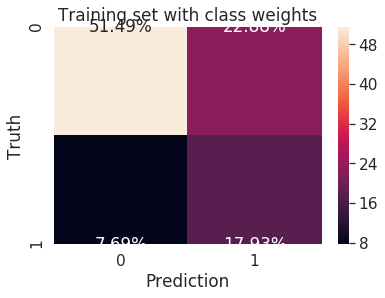

In [90]:
plot_cm(trainCW_ResultDict["cm"],"Training set with class weights")

In [91]:
start = time.time()
validCW_ResultDict = evaluateModel(validPredsAndLabels_CW)
print(f"\n... Executed in {time.time() - start} seconds")

Area under ROC = 0.6940123729896702
Area under PR = 0.40981101795158065
Precision: 0.6925540932508609, Recall: 0.6925540932508609, F Score: 0.6925540932508609
Class 0.0: Precision: 0.8687938426678234, Recall: 0.6910218164032184, F Score: 0.7697774999871418
Class 1.0: Precision: 0.4372405294500659, Recall: 0.6970029295761222, F Score: 0.537376570313683

... Executed in 86.72159576416016 seconds


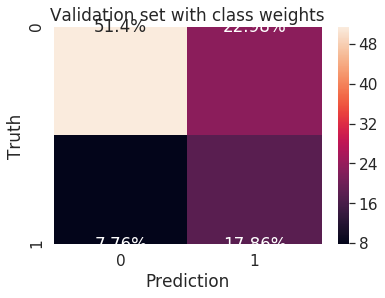

In [92]:
plot_cm(validCW_ResultDict["cm"],"Validation set with class weights")

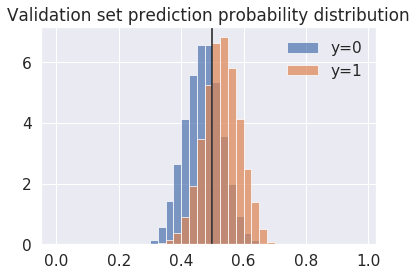

In [93]:
plot_prob(validPredsAndLabels_CW, 0.5)

### Visualize Precision & Recall Graphs

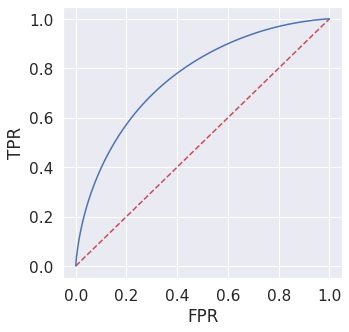


... Executed in 0.24791741371154785 seconds


In [99]:
start = time.time()
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(cvModel_CW.bestModel.stages[-1].summary.roc.select('FPR').collect(),
         cvModel_CW.bestModel.stages[-1].summary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()
print(f"\n... Executed in {time.time() - start} seconds")

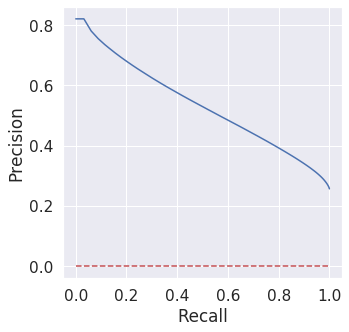


... Executed in 0.25791501998901367 seconds


In [100]:
start = time.time()
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 0], 'r--')
plt.plot(cvModel_CW.bestModel.stages[-1].summary.pr.select('recall').collect(),
         cvModel_CW.bestModel.stages[-1].summary.pr.select('precision').collect())
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()
print(f"\n... Executed in {time.time() - start} seconds")

## 4.d. Trying a Random Forest

Next, we tried running a Random Forest model to compare with our first Logistic Regression model. Here we find an Area under the PR curve to be lower.

In [146]:
from pyspark.ml.classification import RandomForestClassifier

In [150]:
start = time.time()
rf = RandomForestClassifier(labelCol="y", featuresCol="features", numTrees=100)
rf_model = rf.fit(trainDF)
rf_train_predictions = rf_model.transform(trainDF)
rf_valid_predictions = rf_model.transform(validDF)
rf_test_predictions = rf_model.transform(testDF)
print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 13551.50096321106 seconds


In [151]:
start = time.time()
rf_evaluator = BinaryClassificationEvaluator(labelCol="y", rawPredictionCol="prediction",metricName="areaUnderPR")

trainAUPR = rf_evaluator.evaluate(rf_train_predictions)
validAUPR = rf_evaluator.evaluate(rf_valid_predictions)
print(f"Area Under Precision Recall Curve on Train data = {trainAUPR}")
print(f"Area Under Precision Recall Curve on Validation data = {validAUPR}")
print(f"\n... Executed in {time.time() - start} seconds")

Area Under Precision Recall Curve on Train data = 0.2562232381908688
Area Under Precision Recall Curve on Validation data = 0.25622396591195173

... Executed in 1131.6167435646057 seconds


## 4.e. Trying a Gradient Boosted Tree

We tried a Gradient Boosted Tree model which also resulted in lower Area under the PR curve score than the first Logistic Regression model.

In [154]:
from pyspark.ml.classification import GBTClassifier

In [155]:
start = time.time()
gbt = GBTClassifier(labelCol="y", featuresCol="features", maxIter=100)
gbt_model = gbt.fit(trainDF)
gbt_train_predictions = gbt_model.transform(trainDF)
gbt_valid_predictions = gbt_model.transform(validDF)
gbt_test_predictions = gbt_model.transform(testDF)
print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 195144.54537200928 seconds


In [156]:
start = time.time()
gbt_evaluator = BinaryClassificationEvaluator(labelCol="y", rawPredictionCol="prediction",metricName="areaUnderPR")

trainAUPR = gbt_evaluator.evaluate(gbt_train_predictions)
validAUPR = gbt_evaluator.evaluate(gbt_valid_predictions)
print(f"Area Under Precision Recall Curve on Train data = {trainAUPR}")
print(f"Area Under Precision Recall Curve on Validation data = {validAUPR}")
print(f"\n... Executed in {time.time() - start} seconds")

Area Under Precision Recall Curve on Train data = 0.4945870670790396
Area Under Precision Recall Curve on Validation data = 0.49410177103923014

... Executed in 372.9572768211365 seconds


In [158]:
start = time.time()
gbt_model.save("gbt_best_model")
print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 0.7956719398498535 seconds


## 4.f. Submission of Results to Kaggle

Here we submit the results from above and manually execute the following code to compare the outputs of the models we trained above:  

Logistic Regression: testPredsAndLabels  

Logistic Regression with weights: testPredsAndLabels_CW  


In [109]:
kaggleOutput = testPredsAndLabels_CW.select(["id", "probability"])
kaggleOutput = kaggleOutput.rdd.map(lambda x: (int(x['id']), float(x['probability'][1])))

In [110]:
# Convert train file from csv to parquet
start = time.time()
schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("probability", FloatType(), True)])

kaggleDF = sqlContext.createDataFrame(kaggleOutput, schema)
print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 0.02079916000366211 seconds


In [111]:
start = time.time()
kaggleDF.write.mode('overwrite').parquet('kaggle.parquet')
print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 16.969391345977783 seconds


In [112]:
start = time.time()
kaggleDF = sqlContext.read.parquet('kaggle.parquet')
print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 0.04530906677246094 seconds


In [113]:
start = time.time()
pandasDF = kaggleDF.toPandas()
pandasDF.columns=['id','Predicted']
print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 14.878608465194702 seconds


In [114]:
start = time.time()
pandasDF.to_csv('submission.csv', header=True, index=False)
print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 12.937110662460327 seconds


In [115]:
# !kaggle competitions list

In [116]:
!kaggle competitions submit -c criteo-display-ad-challenge -f submission.csv -m "Logistic Regression Submission with Class Weights"

100%|████████████████████████████████████████| 113M/113M [00:06<00:00, 19.0MB/s]
Successfully submitted to Display Advertising Challenge

Based upon our Kaggle submission results, we were happy with our team's performance as it signified that we accomplished our goal of identifying the key features with a Logistic Regression model that performed better than the average submission. We realize that there are many methods that could optimize CTR, but given our time and the many issues that we ran into trying to build a scalable model, we are pleased with our results.

We did notice was that evaulating the performance using area under the precision recall curve did not necessarily translate to the same performance on Kaggle, which uses log loss. We found that Logistic Regression resulted in the largest area under the precision recall curve score, however the Gradient Boosted Tree model ranked highest on the Kaggle leaderboard.

Further modeling efforts could be focused on feature engineering in order to further separate the distribution of the two classes' predicted probabilities.

# 5. Course Concepts

## 5.a. Big Data Scalability: Hadoop vs. Spark

Big Data problems require specialized softwares.  Both Hadoop and Spark are viable options to accomplish this task.  For this project we choose to make use of Spark when creating our model and processing the raw csv files.  Spark is a project by Apache for big data analytics.  The key difference between Spark and Hadoop is that Spark can perform processing in-memory while Hadoop has to read and write to disk.  Therefore, Spark may be up to 100 times faster.

Spark also has an API that supports many more (~80) operators than just map and reduce, which, is a limitation of Hadoop.  Spark uses lazy evaluation, which, can help it to run much faster by creating a pipeline prior to evaluating our calculations.  There are broadcast variables that can be used to share state, which, is a departure from the functional programming paradigm, but becomes useful in tracking state when creating a machine learning algorithm.  

https://spark.apache.org/  

## 5.b. ML Lib

ML Lib is Apache Spark's machine learning library to deal with large data.  It has a number of supported algorithms available through its API such as Decision Trees, Binary Logistic Regression, Multi-class Logistic Regression, Kmeans, clustering, Gaussian Mixture Models, Naive Bayes, and many more.  Because of its ease of use and optimization for use with Spark, and numpy, we choose to utilize ML Lib when implementing our data processing pipeline and machine learning algorithm for this particular problem.

https://spark.apache.org/mllib/  

## 5.c. One Hot Encoding

When dealing with this particular dataset, the majority of the features are categorical variables.  In some cases, these particular categorical features may have upwards of 1 Million distinct potential categories.  However, when dealing with a logistic regression classifier, we must binarize these particular features such that the mathematical operations are able to be performed.  Therefore, a feature that has 3 potential values e.g. "red", "green", or "blue" would instead be transformed into a vector where all of the elements are 0 except for the selected category.  Therefore, in this case, we might represent a "red" object with the vector [1, 0, 0].  In this way we are able to make use of the categorical variables in order to predict the liklihood of clicking on the advertisement.

https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/  

## 5.d. Sparse Representation

When dealing with many categorical variables that are one hot encoded (OHE) we would naturally see a large portion of the feature space is zero.  In fact, in this case where we may have millions of categorical features for a single variable, in practicality almost all of data is zero.  Therefore, in order to save space and allow our algorithm to function, we make use of an alternative representation for our data such as a sparse matrix or a sparse vector.  ML Lib has native support for sparse representations and produces these data structures when using the native API OHE functions.  As an example, we might transform a vector such as this: [0,0,0,0,0,0,0,0,0,1] to {9:1}.  This becomes more important in practice when otherwise we would have millions of zero entries in our vector.

https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html  

## 5.e. Over Fitting & Model Regularization

Regularization is utilized as a means of of solving the overfitting problem.  The concept is that our model is complex and has many parameters.  Humans lack the intuition to understand the interplay between the many parameters of the model.  Therefore we can introduce a regularization term, or a penalty, that is added to our cost function that is determined by the weights of the model.  In this way, we can tune the regularization parameter such that we will minimize the number of non-zero parameters in our model.  Commonly, L2 regularization is known as ridge regression and is defined as the sum of the squares of the weights, while L1 regularization is known as lasso regression and is defined as the sum of the absolute values of the weights.  L2 regularization tends to set the parameters to values close to zero, while L1 regularization tends to set parameters to be exactly zero.  The diagram below shows the effect of the L1 regularization, L2 regularization, and elastic net regularization, which, is a linear combination of the L1 & L2 techniques.  ML Lib supports L1, L2, and elastic net regularization.

Mathematically, the regularization terms are defined as such:

$$ L1 =\lambda \sum_{k=1}^n|\theta_k|$$

$$ L2 =\lambda \sum_{k=1}^n|\theta_k|^2$$

Gareth, James. et al. An Introduction to Statistical Learning with Applications in R.  Springer Publishing.  2015.  
http://www.ds100.org/sp17/assets/notebooks/linear_regression/Regularization.html  

![Regularization](support/regularization.png)

## 5.f. Feature Selection and it's effect on Model Complexity

This dataset was the largest dataset that any of us have worked on and the majority of our time was spent in conducting EDA to understand the numerical and categorical variables as well as what to do with the missing data. We removed features that had too much missing features and we also had to balance the classes as appropriate. Making sure we pick the right features so our model would scale was critical as we ran into many computing issues when trying to apply random forest models.

Chapelle, O., Manavoglu, E., & Rosales, R. (2014). Simple and Scalable Response Prediction for Display Advertising. ACM Transactions on Intelligent Systems and Technology, 5(4), 1-34. doi:10.1145/2532128 https://people.csail.mit.edu/romer/papers/TISTRespPredAds.pdf